In [98]:
import pandas as pd
import numpy as np
import tables as tb
import matplotlib.pyplot as plt
from scipy.stats import trim_mean
from scipy.interpolate import interp1d
from invisible_cities.database  import load_db
from invisible_cities.cities.components import load_dst
import matplotlib.colors as mcolors
%matplotlib widget


In [117]:
def GetBaselineInterp(times, wfs):

    interps = []
    for wf in wfs:

        # Apply trimmed mean over a sliding window
        window_size = 70  # Adjust as needed
        trim_ratio = 0.4  # Trim 10% from each side

        trimmed_wfm = np.array([
            trim_mean(wf[i:i+window_size], proportiontocut=trim_ratio) 
            for i in range(0, len(wf), window_size)
        ])

        # Downsample the time array to match the trimmed values
        trimmed_times = times[::window_size]

        # Interpolate the smoothed data
        interp_func = interp1d(trimmed_times, trimmed_wfm, kind='cubic', bounds_error=False, fill_value=0)  # Cubic interpolation for smoothness
        interps.append(interp_func)

    return interps


def CorrectRawBaseline(wfs):

    corrected_waveforms = []

    for wfm in wfs:
        num_samples = int(25)
        baseline2=np.mean(wfm[0:int(25)])
        wfm = wfm-baseline2
        corrected_waveforms.append(wfm)

    return np.array(corrected_waveforms)


def GetS2Areas(wfs, S2_start, S2_end):

    S2_areas = []

    for wf_sipm in wfs:
        S2_area = wf_sipm[int(S2_start):int(S2_end)]
        S2_area = S2_area[S2_area > 0].sum()
        S2_areas.append(S2_area)

    return S2_areas
    

def BaselineFit(interps, t_start, t_end):

    new_time = np.linspace(t_start,t_end,500)

    slopes = []
    intercepts = []
    for interp in interps:
        interpolated_amplitude = interp(new_time)

        slope, intercept = np.polyfit(new_time, interpolated_amplitude, 1)

        slopes.append(slope)
        intercepts.append(intercept)

    return slopes,intercepts


# Uses the interpolation in a range to fix the baseline
def CorrectDeconvBaseline(t_sipm, tmin, tmax, interps, wfs):
    
    for sipm_no, wf in enumerate(wfs):
        # Apply the interpolation function to waveform time points
        amplitude_interpolated = interps[sipm_no](t_sipm)
        mask = (t_sipm < tmin) | (t_sipm > tmax)
        amplitude_interpolated[mask] = 0

        # Subtract the interpolated amplitude from the waveform amplitude
        wfs[sipm_no] = wf - amplitude_interpolated

    return wfs

def sum_wf(wfs):
    element_wise_sum = np.zeros_like(wfs[0])

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += np.where(array > 4, array, 0)

    return element_wise_sum


In [100]:
filename  = "../data/run_14180_0049_ldc6_trg0.waveforms.h5" 
# filename  = "../data/run_13852_0000_ldc1_trg0.waveforms.h5"
# filename = "../data/run_14710_0000_ldc7_trg0.waveforms.h5"
# filename = "../data/run_14583_0000_ldc1_trg0.waveforms.h5"


raw_evts = pd.read_hdf(filename, '/Run/events')
print(raw_evts.evt_number.unique())

raw_evts = load_dst(filename, 'Run', 'events')
nrwfs = len(raw_evts.evt_number.unique())
print("Number of Waveforms:", nrwfs)


[27760 27767 27774 27781 27788 27795 27802 27809 27816 27823 27830 27837
 27844 27851 27858 27865 27872 27879 27886 27893 27900 27907 27914 27921
 27928 27935 27942 27949 27956 27963 27970 27977 27984 27991 27998 28005
 28012 28019 28026 28033 28040 28047 28054 28061 28068 28075 28082 28089
 28096 28103 28110 28117 28124 28131 28138 28145 28152 28159 28166 28173
 28180 28187 28194 28201 28208 28215 28222 28229 28236 28243 28250 28257
 28264 28271 28278 28285 28292 28299 28306 28313 28320]
Number of Waveforms: 81


In [101]:
# Load in the database for SiPMs

# RUN_NUMBER = 13852
# RUN_NUMBER=13859
RUN_NUMBER = 14180
# RUN_NUMBER = 14710

detector_db = "next100"
datasipm = load_db.DataSiPM(detector_db, RUN_NUMBER)
display(datasipm)


if (RUN_NUMBER == 13850):
    baselinewindow =  1100, 3000
    S2_start    = 990        # S2 integration window start
    S2_end      = 1040       # S2 integration window end

elif (RUN_NUMBER == 13859):
    baselinewindow =  1100, 3000
    S2_start    = 990        # S2 integration window start
    S2_end      = 1040       # S2 integration window end

elif (RUN_NUMBER == 14180):
    baselinewindow =  1700, 1900
    S2_start    = 990        # S2 integration window start
    S2_end      = 1040       # S2 integration window end

elif (RUN_NUMBER == 14498):
    baselinewindow   = 1700, 2600
    noise_lim   = 2500, 2600
    S2_start    = 1590
    S2_end      = 1640

elif (RUN_NUMBER == 14780): 
    baselinewindow   = 1700, 2600
    noise_lim   = 2500, 2600
    S2_start    = 1590
    S2_end      = 1640

elif (RUN_NUMBER == 14710): 
    baselinewindow   = 1800, 3200
    noise_lim   = 2500, 2600
    S2_start    = 1590
    S2_end      = 1640

else:
    print("No run found, using default argon values...")
    baselinewindow =  1100, 3000
    S2_start    = 990        # S2 integration window start
    S2_end      = 1040       # S2 integration window end

,SensorID,ChannelID,Active,X,Y,adc_to_pes,Sigma
0,1000,56013,1,-482.625,-294.825,18.7034,2.40946
1,1001,56012,1,-482.625,-279.275,17.6755,2.28454
2,1002,56015,1,-482.625,-263.725,18.3369,2.46419
3,1003,56014,1,-482.625,-248.175,18.3988,2.78179
4,1004,56029,1,-482.625,-232.625,17.2912,2.79831
...,...,...,...,...,...,...,...
3579,56059,17054,1,490.025,245.425,18.2336,3.07610
3580,56060,17037,1,490.025,260.975,18.3890,2.81721
3581,56061,17036,1,490.025,276.525,18.4060,2.98194
3582,56062,17039,1,490.025,292.075,17.9597,3.35250


On Event: 5
S2 area is: 41854.35999999998
3584
Slope of the fitted line: 0.002002559637822613
Amplitude at time 1650: 0.2629091763072862


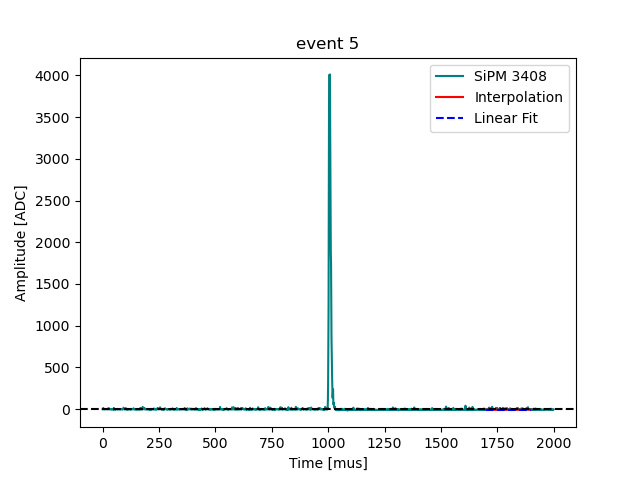

In [116]:
event_number=5
# plot_mode = "highest"
# plot_mode = "summed"
plot_mode = "2398"

with tb.open_file(filename) as file:

    rwf      = file.root.RD.sipmrwf



    wfs = rwf[event_number]

    # # This corrects the baseline from ~50 to zero by shifting it
    wfs = CorrectRawBaseline(wfs)
    # wfs = CorrectRawBaselineSecondary(wfs)

    print("On Event:", event_number)
    
    sp_sipm = 1     # sampling period in mus
    times  = np.arange(wfs[0].size) * sp_sipm

    # Choose which waveform to plot
    if (plot_mode == "highest"):
        index = np.argmax(np.max(wfs, axis=1))
        wf_sipm = wfs[index]
        plot_mode = index
    elif (plot_mode == "summed"):
        wf_sipm =  sum_wf(wfs)
        plot_mode = 0
    else:
        wf_sipm = wfs[int(plot_mode)]

    S2_areas = GetS2Areas(wfs,S2_start, S2_end)
    print("S2 area is:", S2_areas[int(plot_mode)])

    interps = GetBaselineInterp(times, wfs)
    print(len(interps))
    new_time = np.linspace(baselinewindow[0],baselinewindow[1],500)
    # new_time = np.linspace(900,1400,500)
    interpolated_amplitude = interps[int(plot_mode)](new_time)


    slopes, intercepts = BaselineFit(interps, baselinewindow[0],baselinewindow[1])

    wfs = CorrectDeconvBaseline(times, baselinewindow[0],baselinewindow[1], interps, wfs)

    # Print results
    print(f"Slope of the fitted line: {slopes[int(plot_mode)]}")
    print(f"Amplitude at time 1650: {offsets[int(plot_mode)]}")


    plt.figure()
    plt.plot(times, wf_sipm , label = f"SiPM {plot_mode}",  color = "Teal");
    plt.plot(new_time, interpolated_amplitude, label="Interpolation", color="red")
    plt.plot(new_time, slopes[int(plot_mode)] * new_time + intercepts[int(plot_mode)], label="Linear Fit", linestyle="--", color="blue")
    plt.ylabel("Amplitude [ADC]")
    plt.xlabel("Time [mus]")
    plt.axhline(y=0, color='black', linestyle='--')
    plt.legend(loc = "upper right")
    plt.title(f"event {event_number}")
    # plt.xlim(1400, 2600)
    # plt.ylim(-30,30)



In [124]:
wf_sum = 0
with tb.open_file(filename) as file:

    rwf      = file.root.RD.sipmrwf

    for evt_no, wfs in enumerate(rwf):
        print("On Event:", evt_no)

        # if evt_no > 25:
        #     break

        # # This corrects the baseline from ~50 to zero by shifting it
        wfs = CorrectRawBaseline(wfs)
        
        sp_sipm = 1     # sampling period in mus
        times  = np.arange(wfs[0].size) * sp_sipm

        
        interps = GetBaselineInterp(times, wfs)


        wfs = CorrectDeconvBaseline(times, 1250,baselinewindow[1], interps, wfs)

        wf_sipm  =  sum_wf(wfs)
        wf_sum+=wf_sipm


On Event: 0
On Event: 1
On Event: 2
On Event: 3
On Event: 4
On Event: 5
On Event: 6
On Event: 7
On Event: 8
On Event: 9
On Event: 10
On Event: 11
On Event: 12
On Event: 13
On Event: 14
On Event: 15
On Event: 16
On Event: 17
On Event: 18
On Event: 19
On Event: 20
On Event: 21
On Event: 22
On Event: 23
On Event: 24
On Event: 25
On Event: 26
On Event: 27
On Event: 28
On Event: 29
On Event: 30
On Event: 31
On Event: 32
On Event: 33
On Event: 34
On Event: 35
On Event: 36
On Event: 37
On Event: 38
On Event: 39
On Event: 40
On Event: 41
On Event: 42
On Event: 43
On Event: 44
On Event: 45
On Event: 46
On Event: 47
On Event: 48
On Event: 49
On Event: 50
On Event: 51
On Event: 52
On Event: 53
On Event: 54
On Event: 55
On Event: 56
On Event: 57
On Event: 58
On Event: 59
On Event: 60
On Event: 61
On Event: 62
On Event: 63
On Event: 64
On Event: 65
On Event: 66
On Event: 67
On Event: 68
On Event: 69
On Event: 70
On Event: 71
On Event: 72
On Event: 73
On Event: 74
On Event: 75
On Event: 76
On Event:

No handles with labels found to put in legend.


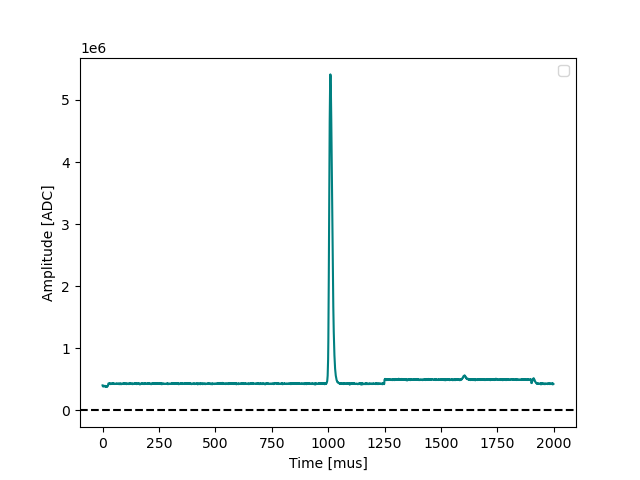

In [125]:

plt.figure()
plt.plot(times, wf_sum , color = "Teal");
plt.ylabel("Amplitude [ADC]")
plt.xlabel("Time [mus]")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend(loc = "upper right")
# plt.xlim(1400, 2600)
# plt.ylim(-30,30)

